In [1]:
# Import Statements


%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_classes=5


#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

In [2]:
from subprocess import check_output
print(check_output(["ls", "./dataset/regression"]).decode("utf8"))

bank32nh.data
bank8FM.data
bostonhousing
cal_housing.data
cpu_act.data
cpu_small.data
house_16H.data
house_8L.data



In [3]:
train_df = pd.read_csv("./dataset/regression/bank32nh.data", sep=' ', header=None)
train_df=train_df.drop(train_df.columns[-1],axis=1)
print(train_df.shape)

columns=["feat"+str(k) for k in range(train_df.shape[1])]
columns[-1]="label"
train_df.columns=columns

train_df.shape

(8192, 33)


(8192, 33)

In [4]:
train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,feat31,label
0,0.413010,0.607442,0.332608,0.406812,-0.151224,1.525222,-0.144368,0.852368,0.412397,1.728169,-0.449231,4.078482,0.232042,-0.323190,0.792235,0.421474,-0.307503,3.086689,0.363949,0.441308,-0.276851,2.0,1.974706,-0.776759,-0.783770,8.0,0.603486,-0.997118,-0.502138,5.0,1.169388,9.0,0.049118
1,-0.602384,0.350618,0.429196,0.414476,-0.124489,4.597991,0.579458,0.651134,0.104394,0.636356,-0.283787,3.546643,0.115860,0.409074,2.152997,0.758680,0.341127,1.478951,0.662488,0.462398,0.339673,6.0,0.798979,-0.002820,-0.080542,2.0,1.125542,-0.983397,-0.107632,5.0,1.186039,7.0,0.242579
2,-0.322881,-0.538491,1.602260,0.039605,0.196023,1.909005,-0.675672,0.963618,0.147458,1.414008,0.495453,0.056459,-0.163151,0.350221,1.124090,1.398160,-0.456921,1.600723,0.650252,-0.247380,0.318002,3.0,0.577355,-0.952645,-0.571600,5.0,1.280392,0.771129,-0.665756,5.0,1.024203,6.0,0.000000
3,-0.233570,-0.936451,1.710192,2.179527,0.438461,4.742055,-0.163625,-0.923273,0.597622,0.118409,0.229981,3.209085,-0.165046,0.012872,0.398148,1.335824,0.119910,13.070052,0.308221,-0.743841,0.258362,4.0,0.760084,-0.198235,-0.205276,2.0,0.509727,-0.579544,0.480094,6.0,1.568492,7.0,0.469045
4,0.403126,0.313367,0.822382,1.393975,0.253435,9.398630,0.312528,0.288321,0.431867,0.110369,0.294665,1.274100,0.328350,-0.288962,0.067075,0.632938,0.148618,3.633846,0.233204,-0.685285,-0.758206,6.0,1.170067,0.573352,0.315217,2.0,0.622033,-0.134747,0.669948,3.0,1.295913,9.0,0.000000


1638.4
[0.0, 0.0001, 0.012395000000000002, 0.051264999999999998, 0.15377600000000002, 1.8201649999999998]
[False False  True ..., False False False]
[False False False ...,  True False False]
[ True False False ..., False  True False]
[False False False ..., False False  True]
[False  True False ..., False False False]
[ 2.  4.  0. ...,  1.  2.  3.]
      feat0     feat1     feat2     feat3     feat4     feat5     feat6  \
0  0.413010  0.607442  0.332608  0.406812 -0.151224  1.525222 -0.144368   
1 -0.602384  0.350618  0.429196  0.414476 -0.124489  4.597991  0.579458   
2 -0.322881 -0.538491  1.602260  0.039605  0.196023  1.909005 -0.675672   
3 -0.233570 -0.936451  1.710192  2.179527  0.438461  4.742055 -0.163625   
4  0.403126  0.313367  0.822382  1.393975  0.253435  9.398630  0.312528   

      feat7     feat8     feat9    feat10    feat11    feat12    feat13  \
0  0.852368  0.412397  1.728169 -0.449231  4.078482  0.232042 -0.323190   
1  0.651134  0.104394  0.636356 -0.283787  3.54

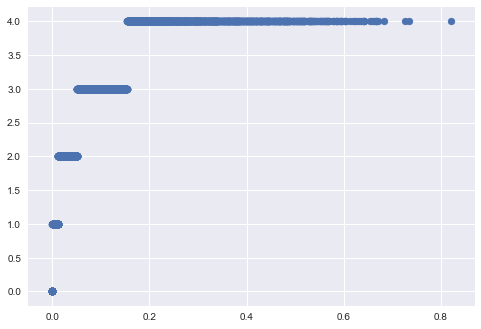

In [5]:
#train_df['label_ord']=train_df['label']
label=train_df.label.values
sorted_idx=np.argsort(train_df.label.values)
num_samples_per_class=train_df.shape[0]/num_classes
print(num_samples_per_class)

bins=[(k*1e-4+label[sorted_idx[np.round(k*num_samples_per_class-1).astype(np.int)]]) for k in range(1,num_classes+1)]
bins.insert(0,0.0)
bins[-1]=bins[-1]+1
print(bins)

label_ord=label.copy()
for k in range(num_classes):
    print(np.all([label>=bins[k], label<bins[k+1]],0))
    label_ord[np.all([label>=bins[k], label<bins[k+1]],0)]=k
    
print(label_ord)


train_df['label_ord']=label_ord
print(train_df.head())

plt.scatter(label,label_ord)
plt.show()


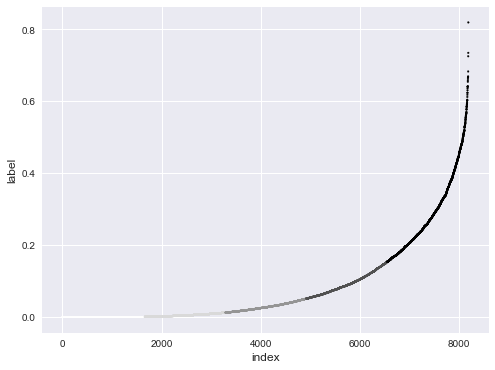

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), label[sorted_idx],s=3,c=np.sort(label_ord[sorted_idx]))
plt.xlabel('index', fontsize=12)
plt.ylabel('label', fontsize=12)


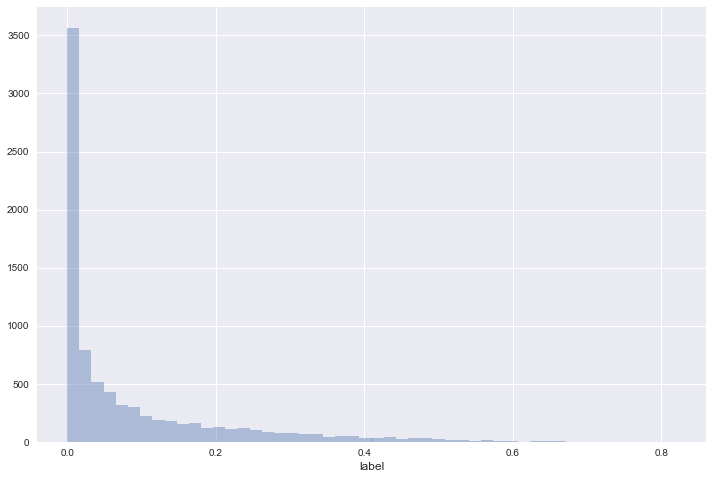

In [7]:
'''ulimit = np.percentile(train_df.label.values, 98)
llimit = np.percentile(train_df.label.values, 2)
train_df['label'].ix[train_df['label']>ulimit] = ulimit
train_df['label'].ix[train_df['label']<llimit] = llimit'''

plt.figure(figsize=(12,8))
sns.distplot(train_df.label.values, bins=50, kde=False)
plt.xlabel('label', fontsize=12)


# Training - Validation Split

In [8]:
feat=train_df.values[:,:-2]

#Normalize the features

feat_max = np.amax(feat,axis=0)
feat_min = np.amin(feat,axis=0)

feat=(feat-feat_min)/(feat_max-feat_min)
feat=feat*2-1

'''feat_mean = np.mean(feat,axis=0)
feat_std = np.std(feat,axis=0)

feat=(feat-feat_mean)/feat_std
'''
label_ord=train_df.values[:,-1].astype(np.int)

print(np.mean(feat,axis=0))
print(np.min(feat,axis=0))
print(feat.shape)
print(label_ord)

fvec=feat.copy()
#label=np.eye(num_classes)[label_ord]
#print(label)


[ -3.46686086e-03  -9.20904637e-04  -8.03606985e-01  -7.73078363e-01
  -3.56635604e-03  -7.72843486e-01  -1.18393606e-04  -9.97569510e-04
  -7.48644283e-01  -8.52985102e-01  -2.84872124e-03  -7.72901335e-01
  -6.64816878e-03  -1.01483779e-03  -7.10571434e-01  -7.82965571e-01
  -5.51937200e-03  -8.13909000e-01   6.02760301e-03   6.02673678e-03
   1.52910570e-03  -3.44319661e-01  -2.20519716e-03  -1.63086888e-02
   1.64501047e-03  -3.35123698e-01  -3.73533559e-03   8.63693798e-04
   1.63181312e-03  -3.29711914e-01  -1.04553928e-02   1.46484375e-03]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(8192, 32)
[2 4 0 ..., 1 2 3]


In [9]:
test_size = 1000

test_idx=sorted_idx[np.floor(np.linspace(0,len(label_ord)-1,test_size)).astype(np.int)]
train_idx = np.setdiff1d(np.arange(0,len(label_ord)),test_idx)



label_ord_test=label_ord[test_idx]
label_ord_train=label_ord[train_idx]
label_test=np.eye(num_classes)[label_ord_test]
label_train=np.eye(num_classes)[label_ord_train]
fvec_test=fvec[test_idx,:]
fvec_train=fvec[train_idx,:]

print(label_ord_test.shape)from sklearn import datasets, linear_model
from sklearn.metrics import mean_absolute_error

# Create linear regression object
regr = linear_model.Ridge(alpha = .5)

# Train the model using training sets
regr.fit(fvec_train, label_ord_train)

# Make predictions using the testing set
label_ord_pred = np.round(regr.predict(fvec_test)).astype(np.int)
label_ord_pred[label_ord_pred<0]=0
label_ord_pred[label_ord_pred>=num_classes]=num_classes-1

label_ord_tr_pred = np.round(regr.predict(fvec_train)).astype(np.int)
label_ord_tr_pred[label_ord_tr_pred<0]=0
label_ord_tr_pred[label_ord_tr_pred>=num_classes]=num_classes-1

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print('Training')
print("Mean absolute error: %.2f"
      % mean_absolute_error(label_ord_tr_pred, label_ord_train))

#CCR 
print("Accuracy: %.2f"
      % np.mean(label_ord_tr_pred==label_ord_train))

# The mean squared error
print('Validation')
print("Mean absolute error: %.2f"
      % mean_absolute_error(label_ord_pred, label_ord_test))

#CCR 
print("Accuracy: %.2f"
      % np.mean(label_ord_pred==label_ord_test))
print(label_ord_train.shape)
print(fvec_test.shape)
print(fvec_train.shape)

(1000,)
(7192,)
(1000, 32)
(7192, 32)


## 1 - Load Data

Before running the code, the data should be downloaded and foldered in the way that is usable for imagefolder function of the PyTorch. The following code assumes that the main directory for the dataset is 'data_dir' and it includes subdirectories for all of the separate classes.

For details on how to create those folders, pleaserefer to 'dataset/Folder_images.ipynb'

In [10]:
'''
Macros
'''
#uniform_sampler=False
batch_size=128

dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_ord_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_ord_test).type(torch.LongTensor))}

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=True,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}


dset_sizes={'train':len(dsets['train']),'val':len(dsets['val'])}
use_gpu = torch.cuda.is_available()

print(dset_sizes)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

{'train': 7192, 'val': 1000}
!!!!! NO CUDA GPUS DETECTED


In [11]:
inputs, classes = next(iter(dset_loaders['val']))
print(inputs.shape)
print(classes.shape)
#print(dsets['train'][0])

torch.Size([128, 32])
torch.Size([128])


## 2- Log Keeping

This section includes the functions defined for the log keeping. Since CNNs require lots of trials, I found it easy to record the properties of the each trial with their performances in an excel file. I also added tnesorboard summaries for every trial and individual text files for showing the details of the network.

Below code declares the required parameters for the network which will be also used inside log keeping

In [70]:
network='resnet34' #Initial network archtiecture.'loaded'forusing a saved network
networkName='resnet18_real_sgd_multisoft_August29  19:06:27' #Directory for the saved network
optimizer='adam' #Optimizer function
iter_loc=14 #Number of the first column in the excel file for writing the results.
end_to_end=True #Booolean to decide whether to train the network end-to-end or not.
lr=0.01 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
pretrained=True 
mse_loss=False #Scalar MSE loss
nclasses=5 #Number of output classes
split=1000
random_seed=1
shuffle=True

'''Multipliers for loss functions'''
single_loss=1.
multi_loss=0.

comment=' ' #Additional comments if any

Let us define the functions for creating a text file and adding networkproperties to an excel file. 

In [13]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs/'+logname+'/Network_properties.txt','w')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    f.write('Random seed: '+str(random_seed)+'\n')
    f.write('Shuffle: '+str(shuffle)+'\n')
    f.write('Validation size: '+str(split)+'\n')
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.write('MSE loss function: '+str(mse_loss)+'\n')
    f.close()

In [14]:
import openpyxl
import time

def writeLog_xlsx(logname='logs.xlsx',iter_loc=14):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    if network=='loaded':
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),networkName,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    else:
        specs=(datetime.now().strftime('%B%d  %H:%M:%S'),network,str(split),str(random_seed),str(shuffle),
               optimizer, crt,str(lr),str(momentum),str(lr_scheduler),str(lr_decay_epoch),str(pretrained),
               str(batch_size))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)

## 3 - Training and Validation

In this part we will define the functions for training a CNN with different properties and loss functions.

The following function takes bunch of properties defined in the beginning of Section-2 as input and creates network using those properties.

In [25]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropouts, num_classes):
        super(Net, self).__init__()
        self.numHidden=len(hidden_sizes)
        setattr(self, 'fc0', nn.Linear(input_size, hidden_sizes[0]))
        setattr(self, 'relu0', nn.ReLU())
        setattr(self, 'drop0', nn.Dropout(p=dropouts[0]))
        for k in range(len(hidden_sizes)-1):
            setattr(self, 'fc'+str(k+1), nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            setattr(self, 'relu'+str(k+1), nn.ReLU())
            setattr(self, 'drop'+str(k+1), nn.Dropout(p=dropouts[k+1]))
        setattr(self, 'fc'+str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        out=self.fc0(x)
        out = self.relu0(out)
        out = self.drop0(out)
        for k in range(self.numHidden-1):
            fc = getattr(self,'fc'+str(k+1))
            relu = getattr(self,'relu'+str(k+1))
            drop = getattr(self,'drop'+str(k+1))
            out = fc(out)
            out = relu(out)
            out = drop(out)
        fc = getattr(self,'fc'+str(self.numHidden))
        out = fc(out)
        return out
    
model=Net(32, [32, 16, 16, 12, 12, 8, 8],[.5 for k in range(7)], 5)
print(model)

Net (
  (fc0): Linear (32 -> 32)
  (relu0): ReLU ()
  (drop0): Dropout (p = 0.5)
  (fc1): Linear (32 -> 16)
  (relu1): ReLU ()
  (drop1): Dropout (p = 0.5)
  (fc2): Linear (16 -> 16)
  (relu2): ReLU ()
  (drop2): Dropout (p = 0.5)
  (fc3): Linear (16 -> 12)
  (relu3): ReLU ()
  (drop3): Dropout (p = 0.5)
  (fc4): Linear (12 -> 12)
  (relu4): ReLU ()
  (drop4): Dropout (p = 0.5)
  (fc5): Linear (12 -> 8)
  (relu5): ReLU ()
  (drop5): Dropout (p = 0.5)
  (fc6): Linear (8 -> 8)
  (relu6): ReLU ()
  (drop6): Dropout (p = 0.5)
  (fc7): Linear (8 -> 5)
)


In [76]:
def network_loader(comment=comment,
                    network=network,
                    networkName=networkName,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    end_to_end=end_to_end,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    pretrained=pretrained,
                    mse_loss=mse_loss,
                    nclasses=nclasses,
                    hidden_sizes = [32, 16, 12, 8],
                    dropouts = [.5 for k in range(4)]):
    
    '''Load the network from pytorch'''
    
    model_ft = Net(32, hidden_sizes , dropouts, nclasses)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

Now define a simple function to be able to run our training in a single line

In [55]:
importlib.reload(ft)
    
def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            network=network,
                                            networkName=networkName,
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            end_to_end=end_to_end,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            pretrained=pretrained,
                                            mse_loss=mse_loss,
                                            nclasses=nclasses)
    
    
    '''Name of the trial'''
    if mse_loss:
        crt='MSE'
    else:
        crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname=network+'_'+'_'+optimizer+'_'+crt+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    best_model, last_model = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=250,
                            multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=mse_loss,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=nclasses)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/'+logname+'_best')
    torch.save(last_model,'./saved_models/'+logname+'_last')
    
    '''Free up the memory'''
    del model_ft


## 4 - Trials

The loss function we used in the experiments is the following,

$$loss(\mathbf{y},\hat{y})=(1-\lambda )loss_{single}(\mathbf{y},\hat{y})+\lambda loss_{multi}(\mathbf{y},\hat{y})$$
where $\mathbf{y}$ is the ground truth and $\hat{y}$ is the prediction.

Now lets test our function for different values of $\lambda$.

In [82]:
lmbda =

single_loss=1.-lmbda
multi_loss = lmbda
run_network()

Epoch 0/49
----------
LR is set to 0.01
train Loss: 0.0106 Acc: 0.1940 CIR-1: 0.4915 RMSE 2.1311
val Loss: 0.0107 Acc: 0.2710 CIR-1: 0.5900 RMSE 1.9834

Epoch 1/49
----------
train Loss: 0.0105 Acc: 0.2184 CIR-1: 0.5185 RMSE 2.0355
val Loss: 0.0102 Acc: 0.3050 CIR-1: 0.6900 RMSE 1.5614

Epoch 2/49
----------
train Loss: 0.0102 Acc: 0.2741 CIR-1: 0.6452 RMSE 1.6966
val Loss: 0.0098 Acc: 0.3420 CIR-1: 0.6500 RMSE 1.6685

Epoch 3/49
----------
train Loss: 0.0099 Acc: 0.2960 CIR-1: 0.6844 RMSE 1.5667
val Loss: 0.0094 Acc: 0.3580 CIR-1: 0.6970 RMSE 1.5531

Epoch 4/49
----------
train Loss: 0.0097 Acc: 0.3219 CIR-1: 0.6799 RMSE 1.5466
val Loss: 0.0090 Acc: 0.3950 CIR-1: 0.7820 RMSE 1.2822

Epoch 5/49
----------
train Loss: 0.0096 Acc: 0.3397 CIR-1: 0.6773 RMSE 1.5419
val Loss: 0.0089 Acc: 0.4080 CIR-1: 0.7300 RMSE 1.4107

Epoch 6/49
----------
train Loss: 0.0095 Acc: 0.3401 CIR-1: 0.6962 RMSE 1.5050
val Loss: 0.0090 Acc: 0.4030 CIR-1: 0.7410 RMSE 1.4153

Epoch 7/49
----------
train Loss: 0.0

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [83]:
mse_loss=False
for lmbda in [.1*k for k in range(4,11)]:
    single_loss=1.-lmbda
    multi_loss = lmbda
    print('Single loss = '+str(single_loss)+', Multi loss = '+str(multi_loss))
    run_network()

Single loss = 0.6, Multi loss = 0.4
Epoch 0/49
----------
LR is set to 0.01
train Loss: 0.0099 Acc: 0.1984 CIR-1: 0.5257 RMSE 1.9611
val Loss: 0.0099 Acc: 0.1990 CIR-1: 0.5980 RMSE 1.7384

Epoch 1/49
----------
train Loss: 0.0098 Acc: 0.2051 CIR-1: 0.5923 RMSE 1.6972
val Loss: 0.0099 Acc: 0.1990 CIR-1: 0.6010 RMSE 1.7300

Epoch 2/49
----------
train Loss: 0.0098 Acc: 0.2063 CIR-1: 0.6046 RMSE 1.6693
val Loss: 0.0098 Acc: 0.2400 CIR-1: 0.6810 RMSE 1.4567

Epoch 3/49
----------
train Loss: 0.0096 Acc: 0.2453 CIR-1: 0.6311 RMSE 1.7018
val Loss: 0.0093 Acc: 0.3550 CIR-1: 0.6550 RMSE 1.6763

Epoch 4/49
----------
train Loss: 0.0094 Acc: 0.2784 CIR-1: 0.6634 RMSE 1.6120
val Loss: 0.0090 Acc: 0.3850 CIR-1: 0.7370 RMSE 1.4181

Epoch 5/49
----------
train Loss: 0.0093 Acc: 0.3027 CIR-1: 0.6648 RMSE 1.5917
val Loss: 0.0087 Acc: 0.3560 CIR-1: 0.7980 RMSE 1.2422

Epoch 6/49
----------
train Loss: 0.0092 Acc: 0.3106 CIR-1: 0.6881 RMSE 1.5206
val Loss: 0.0087 Acc: 0.4060 CIR-1: 0.8100 RMSE 1.1954

E

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0/49
----------
LR is set to 0.01
train Loss: 0.0091 Acc: 0.2019 CIR-1: 0.5246 RMSE 1.9583
val Loss: 0.0092 Acc: 0.2340 CIR-1: 0.6970 RMSE 1.5395

Epoch 1/49
----------
train Loss: 0.0091 Acc: 0.2157 CIR-1: 0.6338 RMSE 1.6528
val Loss: 0.0090 Acc: 0.2720 CIR-1: 0.7390 RMSE 1.4269

Epoch 2/49
----------
train Loss: 0.0088 Acc: 0.2624 CIR-1: 0.6813 RMSE 1.5573
val Loss: 0.0086 Acc: 0.3470 CIR-1: 0.6930 RMSE 1.5304

Epoch 3/49
----------
train Loss: 0.0086 Acc: 0.2823 CIR-1: 0.7129 RMSE 1.4790
val Loss: 0.0083 Acc: 0.3240 CIR-1: 0.6500 RMSE 1.7079

Epoch 4/49
----------
train Loss: 0.0085 Acc: 0.3017 CIR-1: 0.7075 RMSE 1.5031
val Loss: 0.0081 Acc: 0.3510 CIR-1: 0.6990 RMSE 1.5456

Epoch 5/49
----------
train Loss: 0.0084 Acc: 0.3033 CIR-1: 0.6869 RMSE 1.5672
val Loss: 0.0077 Acc: 0.3930 CIR-1: 0.8120 RMSE 1.2128

Epoch 6/49
----------
train Loss: 0.0083 Acc: 0.2978 CIR-1: 0.7215 RMSE 1.4734
val Loss: 0.0078 Acc: 0.3870 CIR-1: 0.7390 RMSE 1.3979

Epoch 7/49
----------
train Loss: 0.0

val Loss: 0.0070 Acc: 0.3730 CIR-1: 0.8240 RMSE 1.1718

Epoch 9/49
----------
train Loss: 0.0076 Acc: 0.3194 CIR-1: 0.7367 RMSE 1.3674
val Loss: 0.0070 Acc: 0.3860 CIR-1: 0.8520 RMSE 1.0932

Epoch 10/49
----------
LR is set to 0.001
train Loss: 0.0074 Acc: 0.3208 CIR-1: 0.7517 RMSE 1.3209
val Loss: 0.0069 Acc: 0.3990 CIR-1: 0.8490 RMSE 1.0890

Epoch 11/49
----------
train Loss: 0.0074 Acc: 0.3301 CIR-1: 0.7603 RMSE 1.3123
val Loss: 0.0068 Acc: 0.4110 CIR-1: 0.8440 RMSE 1.0950

Epoch 12/49
----------
train Loss: 0.0074 Acc: 0.3284 CIR-1: 0.7692 RMSE 1.2840
val Loss: 0.0068 Acc: 0.4180 CIR-1: 0.8430 RMSE 1.0932

Epoch 13/49
----------
train Loss: 0.0073 Acc: 0.3484 CIR-1: 0.7700 RMSE 1.2895
val Loss: 0.0067 Acc: 0.4320 CIR-1: 0.8440 RMSE 1.0831

Epoch 14/49
----------
train Loss: 0.0073 Acc: 0.3419 CIR-1: 0.7735 RMSE 1.2717
val Loss: 0.0067 Acc: 0.4210 CIR-1: 0.8350 RMSE 1.1027

Epoch 15/49
----------
train Loss: 0.0073 Acc: 0.3452 CIR-1: 0.7766 RMSE 1.2831
val Loss: 0.0067 Acc: 0.4120 C

Epoch 17/49
----------
train Loss: 0.0066 Acc: 0.3441 CIR-1: 0.7987 RMSE 1.2515
val Loss: 0.0062 Acc: 0.3840 CIR-1: 0.8560 RMSE 1.0977

Epoch 18/49
----------
train Loss: 0.0066 Acc: 0.3415 CIR-1: 0.7967 RMSE 1.2413
val Loss: 0.0061 Acc: 0.3770 CIR-1: 0.8600 RMSE 1.0863

Epoch 19/49
----------
train Loss: 0.0065 Acc: 0.3468 CIR-1: 0.8005 RMSE 1.2348
val Loss: 0.0061 Acc: 0.4030 CIR-1: 0.8540 RMSE 1.0872

Epoch 20/49
----------
LR is set to 0.00010000000000000002
train Loss: 0.0066 Acc: 0.3458 CIR-1: 0.8031 RMSE 1.2359
val Loss: 0.0061 Acc: 0.4050 CIR-1: 0.8530 RMSE 1.0877

Epoch 21/49
----------
train Loss: 0.0066 Acc: 0.3382 CIR-1: 0.7960 RMSE 1.2449
val Loss: 0.0061 Acc: 0.4050 CIR-1: 0.8550 RMSE 1.0895

Epoch 22/49
----------
train Loss: 0.0065 Acc: 0.3469 CIR-1: 0.8021 RMSE 1.2311
val Loss: 0.0061 Acc: 0.4050 CIR-1: 0.8540 RMSE 1.0886

Epoch 23/49
----------
train Loss: 0.0065 Acc: 0.3498 CIR-1: 0.7957 RMSE 1.2494
val Loss: 0.0061 Acc: 0.4070 CIR-1: 0.8580 RMSE 1.0798

Epoch 24/49


val Loss: 0.0053 Acc: 0.3650 CIR-1: 0.8670 RMSE 1.0867

Epoch 26/49
----------
train Loss: 0.0059 Acc: 0.3405 CIR-1: 0.8094 RMSE 1.1904
val Loss: 0.0053 Acc: 0.3630 CIR-1: 0.8680 RMSE 1.0863

Epoch 27/49
----------
train Loss: 0.0059 Acc: 0.3375 CIR-1: 0.8031 RMSE 1.1964
val Loss: 0.0054 Acc: 0.3640 CIR-1: 0.8660 RMSE 1.0886

Epoch 28/49
----------
train Loss: 0.0058 Acc: 0.3377 CIR-1: 0.8126 RMSE 1.1787
val Loss: 0.0054 Acc: 0.3630 CIR-1: 0.8670 RMSE 1.0877

Epoch 29/49
----------
train Loss: 0.0058 Acc: 0.3452 CIR-1: 0.8167 RMSE 1.1744
val Loss: 0.0053 Acc: 0.3620 CIR-1: 0.8660 RMSE 1.0872

Epoch 30/49
----------
LR is set to 1.0000000000000003e-05
train Loss: 0.0058 Acc: 0.3404 CIR-1: 0.8063 RMSE 1.1940
val Loss: 0.0053 Acc: 0.3620 CIR-1: 0.8660 RMSE 1.0872

Epoch 31/49
----------
train Loss: 0.0058 Acc: 0.3351 CIR-1: 0.8051 RMSE 1.1925
val Loss: 0.0053 Acc: 0.3620 CIR-1: 0.8660 RMSE 1.0872

Epoch 32/49
----------
train Loss: 0.0058 Acc: 0.3375 CIR-1: 0.8087 RMSE 1.1905
val Loss: 0.

train Loss: 0.0052 Acc: 0.3145 CIR-1: 0.8120 RMSE 1.2418
val Loss: 0.0049 Acc: 0.3350 CIR-1: 0.8510 RMSE 1.1432

Epoch 35/49
----------
train Loss: 0.0052 Acc: 0.3120 CIR-1: 0.8159 RMSE 1.2274
val Loss: 0.0049 Acc: 0.3350 CIR-1: 0.8510 RMSE 1.1432

Epoch 36/49
----------
train Loss: 0.0052 Acc: 0.3122 CIR-1: 0.8155 RMSE 1.2317
val Loss: 0.0049 Acc: 0.3350 CIR-1: 0.8510 RMSE 1.1432

Epoch 37/49
----------
train Loss: 0.0053 Acc: 0.3102 CIR-1: 0.8110 RMSE 1.2436
val Loss: 0.0049 Acc: 0.3350 CIR-1: 0.8510 RMSE 1.1432

Epoch 38/49
----------
train Loss: 0.0053 Acc: 0.3084 CIR-1: 0.8102 RMSE 1.2441
val Loss: 0.0049 Acc: 0.3350 CIR-1: 0.8510 RMSE 1.1432

Epoch 39/49
----------
train Loss: 0.0052 Acc: 0.3070 CIR-1: 0.8084 RMSE 1.2475
val Loss: 0.0049 Acc: 0.3360 CIR-1: 0.8510 RMSE 1.1428

Epoch 40/49
----------
LR is set to 1.0000000000000002e-06
train Loss: 0.0052 Acc: 0.3087 CIR-1: 0.8098 RMSE 1.2453
val Loss: 0.0049 Acc: 0.3360 CIR-1: 0.8510 RMSE 1.1428

Epoch 41/49
----------
train Loss: 

val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 43/49
----------
train Loss: 0.0044 Acc: 0.2900 CIR-1: 0.8483 RMSE 1.1676
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 44/49
----------
train Loss: 0.0045 Acc: 0.2896 CIR-1: 0.8394 RMSE 1.1850
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 45/49
----------
train Loss: 0.0044 Acc: 0.2931 CIR-1: 0.8464 RMSE 1.1673
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 46/49
----------
train Loss: 0.0045 Acc: 0.2892 CIR-1: 0.8443 RMSE 1.1686
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 47/49
----------
train Loss: 0.0045 Acc: 0.2830 CIR-1: 0.8401 RMSE 1.1799
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 48/49
----------
train Loss: 0.0045 Acc: 0.2875 CIR-1: 0.8501 RMSE 1.1582
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 1.0863

Epoch 49/49
----------
train Loss: 0.0045 Acc: 0.2878 CIR-1: 0.8436 RMSE 1.1707
val Loss: 0.0041 Acc: 0.3010 CIR-1: 0.8780 RMSE 